In [28]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import colors

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

In [2]:
output = True
N = 9
q = naminoacids

proteome = proteome_path('Human')
seed = 1234
prng = np.random.RandomState(seed)

In [3]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [4]:
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  np.loadtxt('data/%s_matrix.csv.gz' % dataset).astype(int)

In [5]:
for dataset in datasets:
    print(dataset, sample_matrices[dataset].shape)

train (5702936, 9)
test (5646474, 9)
model (5646474, 9)


In [51]:
fis = {}
fijs = {}
cijs = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fi = frequencies(matrix, num_symbols=q, pseudocount=0.0)
    fis[dataset] = fi
    fij = pair_frequencies(matrix, num_symbols=q, fi=fi, pseudocount=0.0)
    fijs[dataset] = fij
    cij = compute_covariance_matrix(fi=fi, fij=fij)
    cijs[dataset] = cij

In [9]:
fijks = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fijk = triplet_frequencies(matrix, num_symbols=q, pseudocount=0.0)
    fijks[dataset] = fijk

In [12]:
cijks = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fij = fijs[dataset]
    fi = fis[dataset]
    fijk = fijks[dataset]
    cijk = compute_cijk(fijk, fij, fi)
    cijks[dataset] = cijk

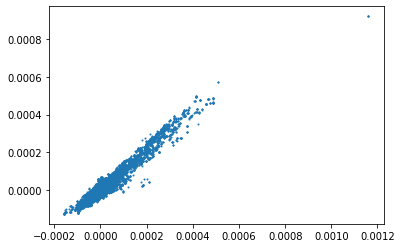

In [13]:
plt.plot(flatten_ijk(cijks['test']), flatten_ijk(cijks['train']), 'o', ms=1)

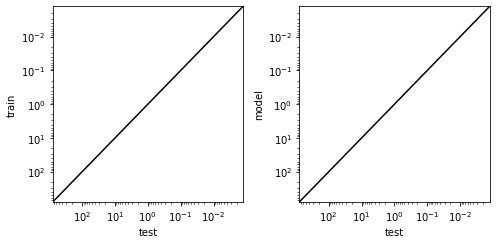

In [45]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['train', 'model']):
    plotting.density_scatter(flatten_ijk(cijks['test']),
                             flatten_ijk(cijks[dataset]),
                             trans=lambda x: np.log(x+1e-3),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset)
for ax in axes:
    max_ = 1.1*flatten_ijk(cijks['test']).max()
    lims = 1/max_, max_
    ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
fig.tight_layout()

In [20]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
independent_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi, np.zeros_like(Jij)), jump, 1e7, nsample=10)

In [21]:
fi_independent = frequencies(independent_matrix, num_symbols=q, pseudocount=0.0)
fij_independent = pair_frequencies(independent_matrix, num_symbols=q, fi=fi_independent, pseudocount=0.0)
fijk_independent = triplet_frequencies(independent_matrix, num_symbols=q, pseudocount=0.0)

In [22]:
cijk_independent = compute_cijk(fijk_independent, fij_independent, fi_independent)

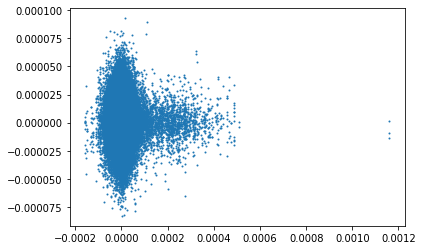

In [23]:
plt.plot(flatten_ijk(cijks['test']), flatten_ijk(cijk_independent), 'o', ms=1)

In [16]:
foldijks = {}
for dataset in datasets:
    fijk = fijks[dataset]
    fi = fis[dataset]
    fold_ijk = fijk / (fi[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis] *
                fi[np.newaxis, :, np.newaxis, np.newaxis, :, np.newaxis] *
                fi[np.newaxis, np.newaxis :, np.newaxis, np.newaxis, :])
    foldijks[dataset] = fold_ijk

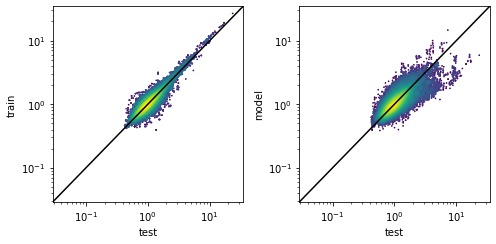

In [42]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['train', 'model']):
    plotting.density_scatter(flatten_ijk(foldijks['test']),
                             flatten_ijk(foldijks[dataset]),
                             trans=lambda x: np.log(x),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset)
for ax in axes:
    max_ = 1.1*flatten_ijk(foldijks['test']).max()
    lims = 1/max_, max_
    ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
fig.tight_layout()

In [52]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [59]:
observables = ['fi', 'cij', 'cijk', 'fold_ijk']
observables_dict = {key: dict() for key in observables}
for dataset in ['train', 'test', 'model']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

KeyError: 'cijk is not a file in the archive'

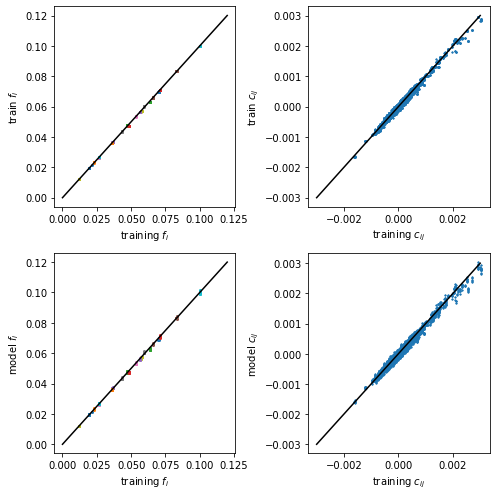

In [54]:
fig, axes = plt.subplots(figsize=(7, 7), ncols=2, nrows=2)

for i, dataset in enumerate(['train', 'model']):
    ax = axes[i, 0]
    ax.plot(fis['test'], fis[dataset], 'o', ms=2)
    ax.set_xlabel('training $f_i$')
    ax.set_ylabel('%s $f_i$'%dataset)
    ax.plot([0, 0.12], [0, 0.12], 'k')

lim = 0.003
for i, dataset in enumerate(['train', 'model']):
    ax = axes[i, 1]
    cij = cijs['test']
    mask = ~np.eye(cij.shape[0], dtype=bool)
    ax.plot(cij[mask].flatten(), cijs[dataset][mask].flatten(), 'o', ms=1)
    ax.set_ylabel('%s $c_{ij}$'%dataset)
    ax.set_xlabel('training $c_{ij}$')
    ax.plot([-lim, lim], [-lim, lim], 'k')

fig.tight_layout()

In [15]:
import evcouplings.align, evcouplings.couplings

Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)

In [16]:
def JijfrominvC(invC):
    Jij = evcouplings.couplings.reshape_invC_to_4d(invC, N, q)
    Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)
    return Jij_zerogauge

In [17]:
cij_flat = compute_flattened_covariance_matrix(fi, fij)
invC = np.linalg.inv(cij_flat)
Jij_mf = JijfrominvC(invC)
hi_mf = evcouplings.couplings.fields(Jij_mf, fi)

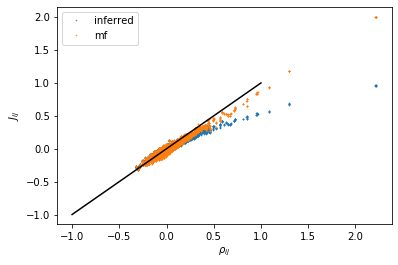

In [26]:
k = N
rhoij = np.zeros(fij.shape)
for i in range(k):
    for j in range(k):
        rhoij[i, j] = fij[i, j]/np.outer(fi[i], fi[j]) - 1.0
mask = np.abs(Jij_zerogauge) > 1e-5
plt.plot(rhoij[mask].flatten(), Jij_zerogauge[mask].flatten(), '.', ms=1, label='inferred')
mask = np.abs(Jij_mf) > 1e-5
plt.plot(rhoij[mask].flatten(), -Jij_mf[mask].flatten(), '.', ms=1, label='mf')
lim = 1.0
plt.plot([-lim, lim], [-lim, lim], 'k-')
plt.xlabel(r'$\rho_{ij}$')
plt.ylabel('$J_{ij}$')
plt.legend()

In [20]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
sample_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi_mf, -Jij_mf), jump, 1e7, nsample=10)

In [21]:
fi_mf = frequencies(sample_matrix, num_symbols=q)
fij_mf = pair_frequencies(sample_matrix, num_symbols=q, fi=fi_model)
cij_mf = compute_covariance_matrix(fi_mf, fij_mf)

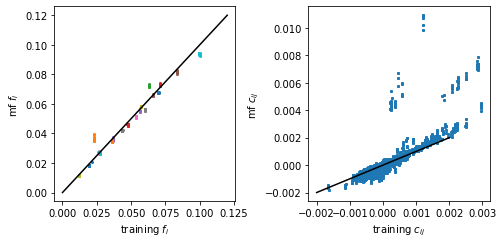

In [22]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)

ax = axes[0]
ax.plot(fi, fi_mf, 'o', ms=2)
ax.set_xlabel('training $f_i$')
ax.set_ylabel('mf $f_i$')
ax.plot([0, 0.12], [0, 0.12], 'k')

lim = 0.002
ax = axes[1]
mask = ~np.eye(cij.shape[0], dtype=bool)
ax.plot(cij[mask].flatten(), cij_mf[mask].flatten(), 'o', ms=2)
ax.set_ylabel('mf $c_{ij}$')
ax.set_xlabel('training $c_{ij}$')
ax.plot([-lim, lim], [-lim, lim], 'k')

fig.tight_layout()